In [27]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [28]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

TrainerUNET = trainers.TrainerUNET

libs reloaded


# UNET

In [29]:
# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q3\Capita Selecta\Project")
DATA_DIR = WORKING_DIR / "Data"
PROGRESS_DIR = WORKING_DIR / "progress_unet"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
VAEMASK_WEIGHTS = WORKING_DIR / "progress_vaemask" / "200_epochs_16_zdim_final" / "model.pth"
VAEGAN_WEIGHTS = WORKING_DIR / "progress_vaegan" / "200_epochs_256_zdim_ema" / "model.pth"

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
N = 15
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
N_EPOCHS = 100
DECAY_LR_AFTER = 95
LEARNING_RATE = 1e-2
TOLERANCE = 0.001  # for early stopping
DISPLAY_FREQ = 5
Number_of_fake = 0
BATCH_SIZE = 32 - Number_of_fake
BATCH_SIZE_VALID = 32
EARLY_STOPPING = False
MINIMUM_VALID_LOSS = 10
exp = str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake"
EXPERIMENT_DIR = PROGRESS_DIR / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

utils.remove_empty_masks(DATA_DIR)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}

mask_generator = generators.VAE(spade=False).to(device)
mask_generator.load_state_dict(torch.load(VAEMASK_WEIGHTS))
mask_generator.eval()

image_generator = generators.VAEGAN(spade=True).to(device)
image_generator.load_state_dict(torch.load(VAEGAN_WEIGHTS))
image_generator.eval()

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

mask_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks=True)
mask_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

# initialise model, optimiser, and loss function
unet_model = u_net.UNet(num_classes=1).to(device)
optimizer = torch.optim.SGD(unet_model.parameters(), lr=LEARNING_RATE, momentum=0.95, nesterov=True, weight_decay=1e-3)


In [30]:
u_net_trainer = TrainerUNET(net=unet_model, 
                            optimizer=optimizer, 
                            progress_dir=EXPERIMENT_DIR, 
                            train_loader=train_loader, 
                            valid_loader=valid_loader, 
                            mask_loader=mask_loader,
                            mask_generator=mask_generator,
                            image_generator=image_generator,
                            TOLERANCE = TOLERANCE,
                            minimum_valid_loss = MINIMUM_VALID_LOSS,
                            Number_of_fake = Number_of_fake,
                            CHECKPOINTS_DIR=EXPERIMENT_DIR, 
                            device=device,
                            early_stopping=EARLY_STOPPING) 

In [31]:
u_net_trainer.train(N_EPOCHS, 1, lambda_lr=lambda_lr)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #000: DiceBCELoss/train = 1.469 | DiceBCELoss/valid = 1.184


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #001: DiceBCELoss/train = 1.143 | DiceBCELoss/valid = 1.045


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #002: DiceBCELoss/train = 0.948 | DiceBCELoss/valid = 0.926


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #003: DiceBCELoss/train = 0.826 | DiceBCELoss/valid = 0.896


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #004: DiceBCELoss/train = 0.789 | DiceBCELoss/valid = 0.892


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #005: DiceBCELoss/train = 0.759 | DiceBCELoss/valid = 0.855


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #006: DiceBCELoss/train = 0.728 | DiceBCELoss/valid = 0.843


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #007: DiceBCELoss/train = 0.683 | DiceBCELoss/valid = 0.815


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #008: DiceBCELoss/train = 0.663 | DiceBCELoss/valid = 0.801


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #009: DiceBCELoss/train = 0.636 | DiceBCELoss/valid = 0.808


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #010: DiceBCELoss/train = 0.611 | DiceBCELoss/valid = 0.760


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #011: DiceBCELoss/train = 0.591 | DiceBCELoss/valid = 0.745


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #012: DiceBCELoss/train = 0.573 | DiceBCELoss/valid = 0.670


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #013: DiceBCELoss/train = 0.564 | DiceBCELoss/valid = 0.646


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #014: DiceBCELoss/train = 0.551 | DiceBCELoss/valid = 0.771


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #015: DiceBCELoss/train = 0.547 | DiceBCELoss/valid = 0.646


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #016: DiceBCELoss/train = 0.535 | DiceBCELoss/valid = 0.687


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #017: DiceBCELoss/train = 0.529 | DiceBCELoss/valid = 0.631


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #018: DiceBCELoss/train = 0.522 | DiceBCELoss/valid = 0.679


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #019: DiceBCELoss/train = 0.516 | DiceBCELoss/valid = 0.629


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #020: DiceBCELoss/train = 0.516 | DiceBCELoss/valid = 0.606


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #021: DiceBCELoss/train = 0.508 | DiceBCELoss/valid = 0.628


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #022: DiceBCELoss/train = 0.498 | DiceBCELoss/valid = 0.630


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #023: DiceBCELoss/train = 0.496 | DiceBCELoss/valid = 0.573


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #024: DiceBCELoss/train = 0.491 | DiceBCELoss/valid = 0.582


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #025: DiceBCELoss/train = 0.487 | DiceBCELoss/valid = 0.582


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #026: DiceBCELoss/train = 0.485 | DiceBCELoss/valid = 0.580


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #027: DiceBCELoss/train = 0.474 | DiceBCELoss/valid = 0.574


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #028: DiceBCELoss/train = 0.475 | DiceBCELoss/valid = 0.651


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #029: DiceBCELoss/train = 0.471 | DiceBCELoss/valid = 0.562


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #030: DiceBCELoss/train = 0.469 | DiceBCELoss/valid = 0.572


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #031: DiceBCELoss/train = 0.467 | DiceBCELoss/valid = 0.573


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #032: DiceBCELoss/train = 0.461 | DiceBCELoss/valid = 0.550


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #033: DiceBCELoss/train = 0.460 | DiceBCELoss/valid = 0.558


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #034: DiceBCELoss/train = 0.456 | DiceBCELoss/valid = 0.557


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #035: DiceBCELoss/train = 0.453 | DiceBCELoss/valid = 0.591


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #036: DiceBCELoss/train = 0.448 | DiceBCELoss/valid = 0.562


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #037: DiceBCELoss/train = 0.447 | DiceBCELoss/valid = 0.558


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #038: DiceBCELoss/train = 0.446 | DiceBCELoss/valid = 0.569


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #039: DiceBCELoss/train = 0.441 | DiceBCELoss/valid = 0.549


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #040: DiceBCELoss/train = 0.438 | DiceBCELoss/valid = 0.565


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #041: DiceBCELoss/train = 0.436 | DiceBCELoss/valid = 0.594


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #042: DiceBCELoss/train = 0.436 | DiceBCELoss/valid = 0.554


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #043: DiceBCELoss/train = 0.430 | DiceBCELoss/valid = 0.549


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #044: DiceBCELoss/train = 0.428 | DiceBCELoss/valid = 0.539


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #045: DiceBCELoss/train = 0.425 | DiceBCELoss/valid = 0.540


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #046: DiceBCELoss/train = 0.426 | DiceBCELoss/valid = 0.541


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #047: DiceBCELoss/train = 0.421 | DiceBCELoss/valid = 0.545


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #048: DiceBCELoss/train = 0.424 | DiceBCELoss/valid = 0.534


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #049: DiceBCELoss/train = 0.420 | DiceBCELoss/valid = 0.547


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #050: DiceBCELoss/train = 0.417 | DiceBCELoss/valid = 0.587


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #051: DiceBCELoss/train = 0.414 | DiceBCELoss/valid = 0.545


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #052: DiceBCELoss/train = 0.411 | DiceBCELoss/valid = 0.546


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #053: DiceBCELoss/train = 0.410 | DiceBCELoss/valid = 0.577


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #054: DiceBCELoss/train = 0.409 | DiceBCELoss/valid = 0.553


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #055: DiceBCELoss/train = 0.408 | DiceBCELoss/valid = 0.537


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #056: DiceBCELoss/train = 0.406 | DiceBCELoss/valid = 0.540


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #057: DiceBCELoss/train = 0.402 | DiceBCELoss/valid = 0.574


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #058: DiceBCELoss/train = 0.402 | DiceBCELoss/valid = 0.552


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #059: DiceBCELoss/train = 0.400 | DiceBCELoss/valid = 0.525


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #060: DiceBCELoss/train = 0.401 | DiceBCELoss/valid = 0.529


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #061: DiceBCELoss/train = 0.398 | DiceBCELoss/valid = 0.538


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #062: DiceBCELoss/train = 0.394 | DiceBCELoss/valid = 0.558


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #063: DiceBCELoss/train = 0.395 | DiceBCELoss/valid = 0.553


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #064: DiceBCELoss/train = 0.393 | DiceBCELoss/valid = 0.529


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #065: DiceBCELoss/train = 0.392 | DiceBCELoss/valid = 0.539


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #066: DiceBCELoss/train = 0.389 | DiceBCELoss/valid = 0.556


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #067: DiceBCELoss/train = 0.389 | DiceBCELoss/valid = 0.537


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #068: DiceBCELoss/train = 0.387 | DiceBCELoss/valid = 0.527


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #069: DiceBCELoss/train = 0.387 | DiceBCELoss/valid = 0.537


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #070: DiceBCELoss/train = 0.385 | DiceBCELoss/valid = 0.546


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #071: DiceBCELoss/train = 0.384 | DiceBCELoss/valid = 0.567


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #072: DiceBCELoss/train = 0.382 | DiceBCELoss/valid = 0.525


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #073: DiceBCELoss/train = 0.380 | DiceBCELoss/valid = 0.543


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #074: DiceBCELoss/train = 0.379 | DiceBCELoss/valid = 0.562


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #075: DiceBCELoss/train = 0.381 | DiceBCELoss/valid = 0.535


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #076: DiceBCELoss/train = 0.378 | DiceBCELoss/valid = 0.537


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #077: DiceBCELoss/train = 0.375 | DiceBCELoss/valid = 0.548


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #078: DiceBCELoss/train = 0.373 | DiceBCELoss/valid = 0.530


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #079: DiceBCELoss/train = 0.373 | DiceBCELoss/valid = 0.532


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #080: DiceBCELoss/train = 0.372 | DiceBCELoss/valid = 0.526


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #081: DiceBCELoss/train = 0.376 | DiceBCELoss/valid = 0.548


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #082: DiceBCELoss/train = 0.373 | DiceBCELoss/valid = 0.540


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #083: DiceBCELoss/train = 0.368 | DiceBCELoss/valid = 0.538


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #084: DiceBCELoss/train = 0.371 | DiceBCELoss/valid = 0.527


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #085: DiceBCELoss/train = 0.368 | DiceBCELoss/valid = 0.536


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #086: DiceBCELoss/train = 0.369 | DiceBCELoss/valid = 0.554


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #087: DiceBCELoss/train = 0.365 | DiceBCELoss/valid = 0.549


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #088: DiceBCELoss/train = 0.365 | DiceBCELoss/valid = 0.538


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #089: DiceBCELoss/train = 0.364 | DiceBCELoss/valid = 0.525


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #090: DiceBCELoss/train = 0.365 | DiceBCELoss/valid = 0.532


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #091: DiceBCELoss/train = 0.361 | DiceBCELoss/valid = 0.553


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #092: DiceBCELoss/train = 0.360 | DiceBCELoss/valid = 0.576


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #093: DiceBCELoss/train = 0.358 | DiceBCELoss/valid = 0.543


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #094: DiceBCELoss/train = 0.360 | DiceBCELoss/valid = 0.533


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #095: DiceBCELoss/train = 0.357 | DiceBCELoss/valid = 0.562


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #096: DiceBCELoss/train = 0.359 | DiceBCELoss/valid = 0.541


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #097: DiceBCELoss/train = 0.357 | DiceBCELoss/valid = 0.571


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #098: DiceBCELoss/train = 0.355 | DiceBCELoss/valid = 0.550


  0%|          | 0/36 [00:00<?, ?it/s]

KeyboardInterrupt: 

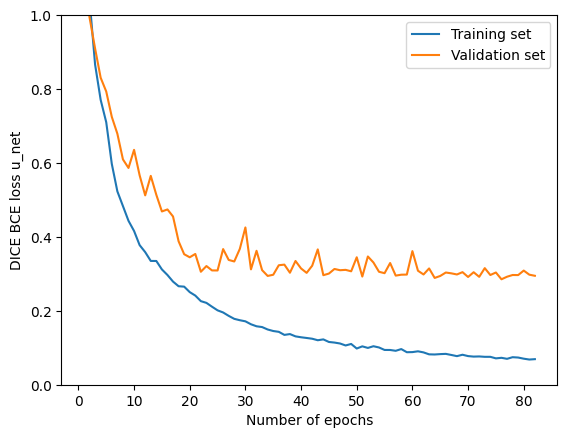

In [ ]:
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.train_losses[0])
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('DICE BCE loss u_net')
plt.ylim([0, 1])
plt.legend(['Training set', 'Validation set'])
plot_name = 'DICE_BCE_LOSS_'+ str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake.png"
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)